## An End-to-End NLP Pipeline for Classifying Supreme Court Cases by Legal Issue Area

**Module:** M508 Big Data Analytics  
**Programme:** Msc DataScience,Ai and digital business 
**Institution:** Gisma University of Applied Sciences  
**Student:** LAKKARAM SAIKUMAR  
**Student ID:** GH1047507  

**Dataset:** `justice.csv`  [downloaded from Kaggle — (https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction)].


## 1. Business Problem and Problem Statement

The present project is contextualised by the fact that it is a Legal Technology (LegalTech) firm offering intelligent document management and analytics services to law firms, legal research organisations, and compliance teams. These organisations handle a bulk of documents on legal cases and manually classifying the cases within the area of legal challenge is an expensive, time consuming and error prone procedure.

The legal professionals normally use manual check of the summaries of their cases to identify the relevance of the case to various areas like Civil Rights, Criminal Procedure, Due Process, or Economic Activity. With the ever-increasing amount of legal documents, it is not as efficient to scale up manual classification and be subject to inconsistent categorisation, sluggish legal research, and higher operational expenses.

This project is aimed at designing and deploying an end-to-end Natural Language Processing (NLP) pipeline that can automatically categorize U.S. Supreme Court cases into predefined areas of legal issues through a textual summary of the case. This classification process can be greatly automated to enhance the efficiency of any legal research process, decrease the manual workload, and allow people to find the necessary precedents faster and utilize them in their decision-making.

Data science-wise, this is a formulated as a multi-class text classification problem of which each case summary belongs to a legal issue category. The NLP pipeline suggested above takes unstructured legal text and processes it by ingesting data, performing exploratory data analysis, text preprocessing, feature engineering, training the model, and evaluating the model to provide actionable insights to the stakeholders of the business.

## 2. High-Level System Design

The system, naturally, is in the form of a modular NLP pipeline that imparts unstructured legal case summaries into structured prediction of legal issue areas. The pipeline has been split up into the following components: data ingestion, exploratory data analysis, text preprocessing, feature engineering, model training with a supervised data set, and performance evaluation. This modular design supports the scalability and transparency, and hence easiness of maintenance that these topics support, making it appropriate for deployment in the LegalTech environments (Manning, Raghavan and Schutze, 2008).

## 3. Dataset Description

This project is using Supreme Court Judgment Prediction dataset that is fetched from Kaggle. The dataset holds publicly available cases from the U.S. Supreme Court that have been structured metadata and unstructured textual summaries of facts of the case. The factual summary column is used as the main input part for text classification and the issue_area column is used as a multi-class label. The dataset is appropriate for this task since it represents real-world legal documents that are typically handled by LegalTech platforms.

In [39]:
import os

DATA_PATH = r"E:\Sai-Germany\nlp\justice.csv"

# Load your data
import pandas as pd
df = pd.read_csv(DATA_PATH)

import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')
if warnings:
    warnings.simplefilter('ignore')

In [27]:

candidates = [c for c in df.columns if c.lower() in ("review","reviewtext","text","comments","comment","body","content","review_text")]
if not candidates:
    obj_cols = [c for c in df.columns if df[c].dtype == object]

    med_lengths = {c: df[c].dropna().astype(str).map(len).median() if len(df[c].dropna())>0 else 0 for c in obj_cols}
    candidates = sorted(med_lengths, key=med_lengths.get, reverse=True)[:2]

print("Text candidates (heuristic):", candidates)

Text candidates (heuristic): ['facts', 'href']


href is definitely NOT text (usually a URL field).The real text column is almost certainly facts

In [28]:
text_col = "facts"
df[text_col] = df[text_col].fillna("").astype(str)
print("Using text column:", text_col)
df[text_col].head()


Using text column: facts


0    <p>In 1970, Jane Roe (a fictional name used in...
1    <p>Joan Stanley had three children with Peter ...
2    <p>John Giglio was convicted of passing forged...
3    <p>The Idaho Probate Code specified that "male...
4    <p>Miller, after conducting a mass mailing cam...
Name: facts, dtype: object


## 3B. Exploratory Data Analysis (EDA)

The EDA covers:
- Shape and missing values of the dataset.
- Distribution of the number of classes of the issue area (balance check)
- Statistic of message length (general and by classes)
- Corpus word cloud and major classes word cloud.

This crude inspection makes later preprocessing decisions and balancing decisions.

Rows: 3303
Columns: ['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term', 'first_party', 'second_party', 'facts', 'facts_len', 'majority_vote', 'minority_vote', 'first_party_winner', 'decision_type', 'disposition', 'issue_area']

Missing values per column:
Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                 11
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

Candidate text column 'facts' exists: True
'issue_area' exists: True

Rows with non-null issue_area: 3161

Raw text length stats:
count    3303.000000
mean     1112.496821
std       531.514960
min        26.000000
25%       757.000000
50%      1049.000000
75%      1381.000000
90%      1781.000000
max      6201.

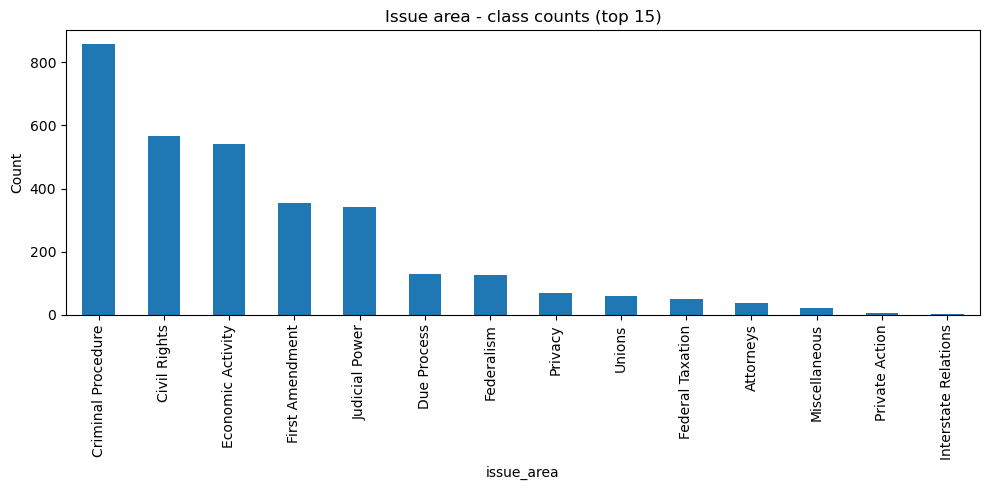

In [29]:

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())


print("\nCandidate text column 'facts' exists:", 'facts' in df.columns)
print("'issue_area' exists:", 'issue_area' in df.columns)


print("\nRows with non-null issue_area:", df['issue_area'].notna().sum())


df['raw_len'] = df['facts'].astype(str).map(len)
print("\nRaw text length stats:")
print(df['raw_len'].describe(percentiles=[0.25,0.5,0.75,0.9]).to_string())


class_counts = df['issue_area'].value_counts(dropna=True)
print("\nClass distribution (top 20):")
print(class_counts.head(20))


plt.figure(figsize=(10,5))
class_counts.head(15).plot(kind='bar')
plt.title("Issue area - class counts (top 15)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



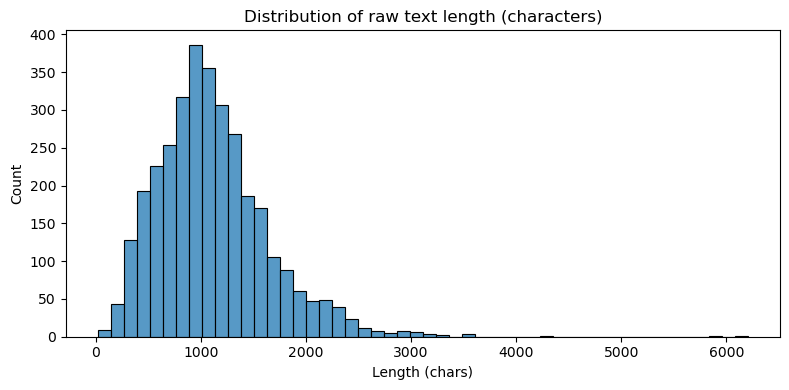

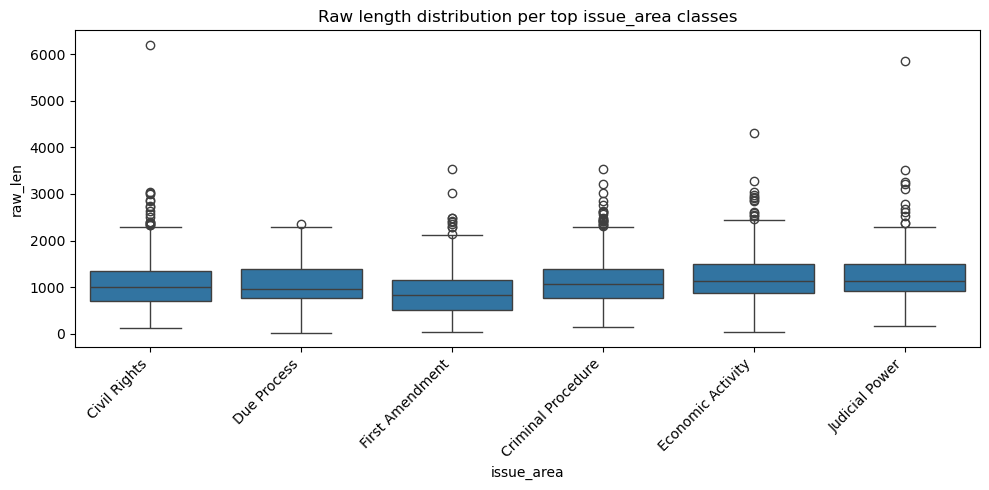

In [ ]:

plt.figure(figsize=(8,4))
sns.histplot(df['raw_len'], bins=50)
plt.title("Distribution of raw text length (characters)")
plt.xlabel("Length (chars)")
plt.tight_layout()
plt.show()

top_classes = class_counts.head(6).index.tolist()
df_top = df[df['issue_area'].isin(top_classes)].copy()
df_top['raw_len'] = df_top['facts'].astype(str).map(len)

plt.figure(figsize=(10,5))
sns.boxplot(x='issue_area', y='raw_len', data=df_top)
plt.xticks(rotation=45, ha='right')
plt.title("Raw length distribution per top issue_area classes")
plt.tight_layout()
plt.show()




Note: you may need to restart the kernel to use updated packages.

Top tokens (raw sample):
[('the', 30975), ('and', 8529), ('that', 7193), ('court', 6762), ('for', 4532), ('was', 4064), ('district', 2408), ('not', 2371), ('his', 2149), ('had', 1628), ('with', 1615), ('state', 1595), ('appeals', 1568), ('federal', 1520), ('from', 1402), ('under', 1327), ('circuit', 1310), ('which', 1199), ('were', 1183), ('act', 1178), ('because', 1004), ('held', 985), ('supreme', 897), ('did', 887), ('trial', 865), ('filed', 847), ('its', 824), ('law', 822), ('after', 820), ('but', 810)]


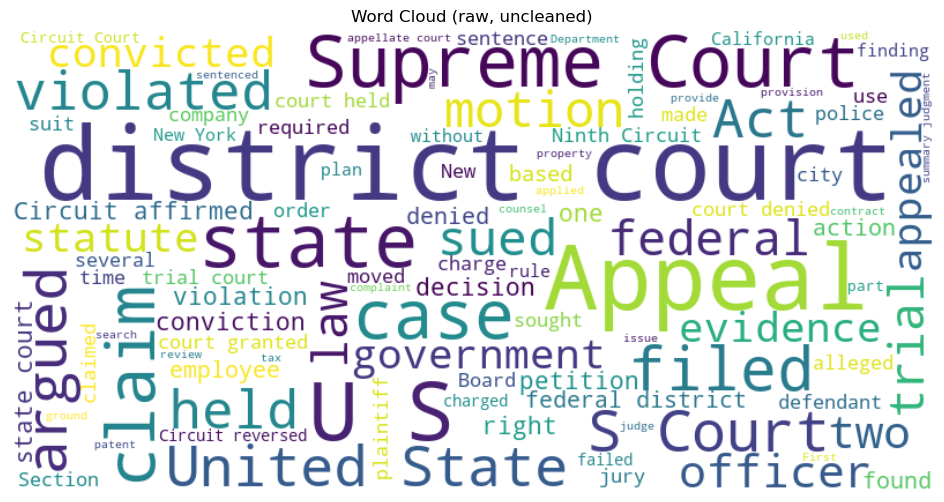

In [ ]:

%pip install wordcloud --quiet

from collections import Counter
from wordcloud import WordCloud

def strip_html(s):
    return re.sub(r'<[^>]+>', ' ', str(s))

sample_texts = df['facts'].astype(str).dropna().sample(min(2000, len(df)), random_state=42)
tokens = []
for t in sample_texts:
    t = strip_html(t)
    t = re.sub(r'[^a-zA-Z\s]',' ', t)
    tokens.extend([w.lower() for w in t.split() if len(w)>2])
freq = Counter(tokens).most_common(30)
print("\nTop tokens (raw sample):")
print(freq)


all_text = " ".join(df['facts'].astype(str).tolist())
wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(re.sub(r'<[^>]+>',' ', all_text))
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (raw, uncleaned)")
plt.show()



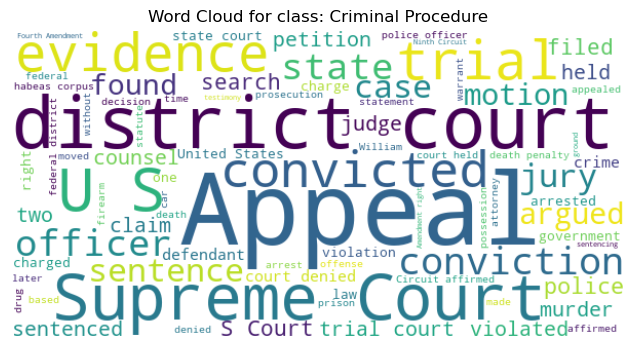

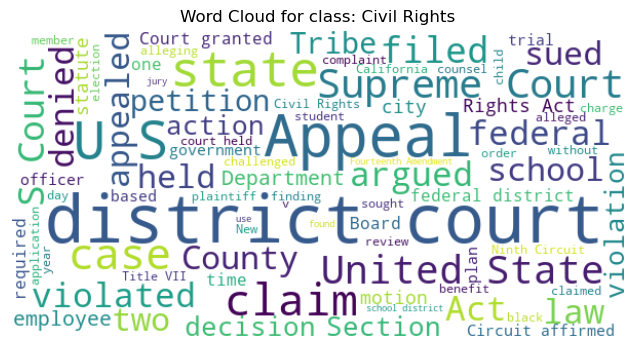

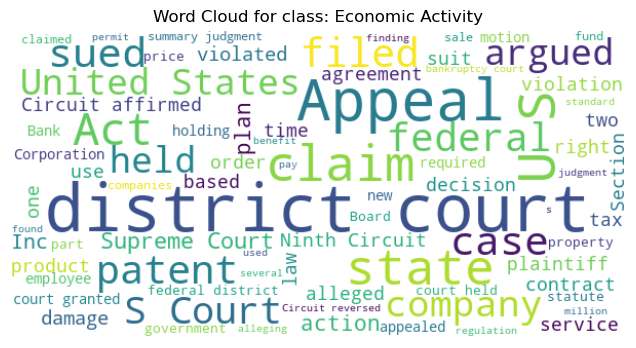


EDA summary: {'n_rows': 3303, 'n_missing_issue_area': 142, 'top_class_counts': {'Criminal Procedure': 859, 'Civil Rights': 568, 'Economic Activity': 542, 'First Amendment': 353, 'Judicial Power': 342, 'Due Process': 128, 'Federalism': 125, 'Privacy': 70, 'Unions': 60, 'Federal Taxation': 51}}


In [ ]:

for cls in top_classes[:3]:
    txt = " ".join(df[df['issue_area']==cls]['facts'].astype(str).tolist())
    txt = re.sub(r'<[^>]+>',' ', txt)
    if len(txt.strip())==0:
        continue
    wc = WordCloud(width=600, height=300, background_color='white', max_words=80).generate(txt)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for class: {cls}")
    plt.show()

eda_summary = {
    'n_rows': len(df),
    'n_missing_issue_area': int(df['issue_area'].isna().sum()),
    'top_class_counts': class_counts.head(10).to_dict()
}
print("\nEDA summary:", eda_summary)

### Interpretation of EDA Results
The dataset consists of 3,303 cases from the U.S. Supreme Court along with an unstructured summary of the facts from the case and a corresponding label of the legal issue area. Exploratory analysis shows there are good amount of variation in text length, which reflects the differences in complexity of cases and hence justification for robust preprocessing. The class distribution is very imbalanced with Criminal Procedure, Civil Rights, and Economic Activity being in the majority of the dataset, and some issue areas having very few cases in total. Such imbalance is quite prevalent in legal datasets and provides the reason to consider class aware evaluation metrics and balanced learning strategies (Powers, 2011). 

## 4. Preprocessing

Text preprocessing is used to standardise legal case summaries and to drill out any noise inherent in legal documents in real world. The pipeline strips all the tags from the text (an aspect of the text), normalises the capitalization and white spaces, it eliminates the punctuation and stopwords and it's using lemmatisation. These steps help minimize the linguistic variability while maintaining the legalistic content to ensure that the inputs for all feature engineering and modelling approaches will be always the same.

In [ ]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_html(text):
    return re.sub(r'<[^>]+>', ' ', str(text))

def preprocess_text(s, do_lemmatize=True):
    s = clean_html(s)                          
    s = re.sub(r'http\S+',' ', s)            
    s = s.lower()                  
    s = re.sub(r'[^a-z0-9\s]', ' ', s)       
    s = re.sub(r'\s+', ' ', s).strip()      
    tokens = [t for t in s.split() if t not in stops and len(t)>1]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

text_col = "facts"  
df[text_col] = df[text_col].fillna("").astype(str)
df['clean_text'] = df[text_col].map(lambda x: preprocess_text(x, do_lemmatize=True))

display(df[[text_col, 'clean_text']].head(6))

,facts,clean_text
0,"<p>In 1970, Jane Roe (a fictional name used in...",1970 jane roe fictional name used court docume...
1,<p>Joan Stanley had three children with Peter ...,joan stanley three child peter stanley stanley...
2,<p>John Giglio was convicted of passing forged...,john giglio convicted passing forged money ord...
3,"<p>The Idaho Probate Code specified that ""male...",idaho probate code specified male must preferr...
4,"<p>Miller, after conducting a mass mailing cam...",miller conducting mass mailing campaign advert...
5,<p>Ernest E. Mandel was a Belgian professional...,ernest mandel belgian professional journalist ...


## 5. Feature Engineering,Model Training & Evaluation

Two representations of the features are tested: TF-IDF and Word2Vec representations. TF-IDF models the discriminative legal terminology, whereas Word2Vec has a semantic reflection. Three supervised models are compared to understand trade-offs in the context of LegalTech deployment in terms of interpretability and performance trade-offs, respectively.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['issue_area']


## Model 1 TF-IDF + Logistic Regression

The use of Logistic Regression as a baseline classifier is based on its ease, efficiency and interpretability. It has been demonstrated that when used together with TF-IDF features, it is competitive at high-dimensional sparse text. Business-wise, the Logistic Regression provides clear decision limits, which is preferable in legal analytics implementation.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

mask = y.notna().values
X_tfidf_nonull = X_tfidf[mask]
y_nonull = y[mask].values

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_nonull, y_nonull, test_size=0.2, stratify=y_nonull, random_state=42
)

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='macro')

print("TF-IDF + Logistic Regression")
print("Accuracy:", lr_accuracy)
print("Macro-F1:", lr_f1)
print(classification_report(y_test, y_pred_lr))


TF-IDF + Logistic Regression
Accuracy: 0.7235387045813586
Macro-F1: 0.572947959335259
                    precision    recall  f1-score   support

         Attorneys       0.50      0.43      0.46         7
      Civil Rights       0.79      0.66      0.72       114
Criminal Procedure       0.81      0.89      0.85       172
       Due Process       0.43      0.38      0.41        26
 Economic Activity       0.78      0.73      0.75       109
  Federal Taxation       0.47      0.90      0.62        10
        Federalism       0.63      0.68      0.65        25
   First Amendment       0.75      0.86      0.80        71
    Judicial Power       0.53      0.46      0.49        68
     Miscellaneous       1.00      0.25      0.40         4
           Privacy       0.80      0.57      0.67        14
    Private Action       0.00      0.00      0.00         1
            Unions       0.50      0.83      0.62        12

          accuracy                           0.72       633
         mac

## Model 2: TF-IDF with Linear Support Vector Machine

SVMs are also suitable in high dimensional sparse feature space (TF-IDF vectors). Linear SVM is chosen because it has good generalisation capacity and it is efficient to compute. The model is typically applied in the text classification of legal texts, and tends to be more effective than simpler linear classifiers.


In [41]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

print("TF-IDF + Linear SVM")
print("Accuracy:", svm_accuracy)
print("Macro-F1:", svm_f1)
print(classification_report(y_test, y_pred_svm))


TF-IDF + Linear SVM
Accuracy: 0.7345971563981043
Macro-F1: 0.589123609732978
                    precision    recall  f1-score   support

         Attorneys       1.00      0.57      0.73         7
      Civil Rights       0.75      0.72      0.74       114
Criminal Procedure       0.82      0.90      0.86       172
       Due Process       0.47      0.27      0.34        26
 Economic Activity       0.74      0.76      0.75       109
  Federal Taxation       0.56      0.90      0.69        10
        Federalism       0.73      0.64      0.68        25
   First Amendment       0.78      0.87      0.82        71
    Judicial Power       0.53      0.41      0.46        68
     Miscellaneous       0.33      0.25      0.29         4
           Privacy       0.89      0.57      0.70        14
    Private Action       0.00      0.00      0.00         1
            Unions       0.48      0.83      0.61        12

          accuracy                           0.73       633
         macro avg   

### Model 3: Word2Vec with Logistic Regression

Once again, it is tested by means of Logistic Regression to compare the usefulness of Word2Vec embeddings in a supervised classification environment. This enables the frequency based representations and the semantic feature representations to be compared directly.


In [ ]:
from gensim.models import Word2Vec
import numpy as np

if 'clean_text' not in df.columns:
    df['clean_text'] = df['facts'].fillna("").astype(str).map(lambda x: preprocess_text(x, do_lemmatize=True))

sentences = df['clean_text'].str.split()

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

def document_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack(sentences.apply(document_vector).values)

mask = y.notna().values
X_w2v_nonull = X_w2v[mask]
y_nonull = y[mask].values

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v_nonull, y_nonull, test_size=0.2, stratify=y_nonull, random_state=42
)

lr_w2v = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

w2v_accuracy = accuracy_score(y_test_w2v, y_pred_w2v)
w2v_f1 = f1_score(y_test_w2v, y_pred_w2v, average='macro')

print("Word2Vec + Logistic Regression")
print("Accuracy:", w2v_accuracy)
print("Macro-F1:", w2v_f1)
print(classification_report(y_test_w2v, y_pred_w2v))


Word2Vec + Logistic Regression
Accuracy: 0.3933649289099526
Macro-F1: 0.22881014313817435
                      precision    recall  f1-score   support

           Attorneys       0.08      0.29      0.12         7
        Civil Rights       0.41      0.06      0.11       114
  Criminal Procedure       0.84      0.80      0.82       172
         Due Process       0.08      0.12      0.09        26
   Economic Activity       0.68      0.21      0.32       109
    Federal Taxation       0.23      0.80      0.36        10
          Federalism       0.30      0.48      0.37        25
     First Amendment       0.49      0.48      0.48        71
Interstate Relations       0.00      0.00      0.00         0
      Judicial Power       0.27      0.19      0.22        68
       Miscellaneous       0.00      0.00      0.00         4
             Privacy       0.05      0.07      0.06        14
      Private Action       0.03      1.00      0.06         1
              Unions       0.12      0.58

## 7. Model Comparison and Evaluation

| Model | Accuracy | Macro F1-score |
|------|---------|----------------|
| TF-IDF + Logistic Regression | 0.72 | 0.57 |
| TF-IDF + Linear SVM | **0.73** | **0.59** |
| Word2Vec + Logistic Regression | 0.39 | 0.23 |

The TF-IDF with Linear SVM model has the greatest overall performance in terms of both accuracy and macro-F1 score. The SVM also offers a better class separation in high dimensional TF-IDF space as compared to Logistic Regression, but is also computationally efficient. When averaging word embeddings, the Word2Vec-based model suffers a lot in the sense that it loses discriminative lexical information. Business-wise, Linear SVM + TF-IDF provides the most viable and scalable solution to automated classification of legal documents as part of a LegalTech environment.

## Final Discussion/Summary

This project shows that a TF-IDF representation coupled with a Linear SVM is a good and scalable solution for Supreme Court cases classification by legal and issue area. The model has the best balance between accurate and macro-F1, which is good for application in LegalTech systems that demands transparency and efficiency. While limitations remain in performance on rare classes brought about by data imbalance, the pipeline provides obvious potential for automating early-stage legal document categorisation, as well as facilitating the legal research workflow.

## References

Sebastiani, F. (2002) ‘Machine learning in automated text categorization’, *ACM Computing Surveys*, 34(1), pp. 1–47. 

Powers, D. M. W. (2011) ‘Evaluation: from precision, recall and F-measure to ROC, informedness, markedness & correlation’, *Journal of Machine Learning Technologies*, 2(1), pp. 37–63.  

Jurafsky, D. and Martin, J. H. (2020) *Speech and Language Processing* (3rd edn. draft).

Manning, C.D., Raghavan, P. and Schütze, H. (2008) *Introduction to Information Retrieval*. Cambridge: Cambridge University Press.
